# Imports

In [1]:
# Hiding tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
# Python Imports
import os
import shutil
import random
import glob
import itertools

# Third-party Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from sklearn.metrics import confusion_matrix, classification_report

# Data processing

In [3]:
home_dir = os.path.expanduser('~')
project_dir = f'{home_dir}/Projects/fire'

In [4]:
# changing into dataset directory
os.chdir(f'{project_dir}/data/fire-vs-without-fire')

In [5]:
# organize data into train, valid, test dirs
if os.path.isdir('train/with_fire') is False:
    
    labels = ['with_fire', 'without_fire']
    folders = ['train', 'valid', 'test']
    amounts = [850, 50, 50]
    
    for label in labels:
        for folder, amount in zip(folders, amounts):
            # create new folder for the separate data
            os.makedirs(f'{folder}/{label}')
            
            # random select entries
            for c in random.sample(os.listdir(label), amount):
                shutil.move(f'{label}/{c}', f'{folder}/{label}')
        
        # remove original folder
        os.rmdir(label)

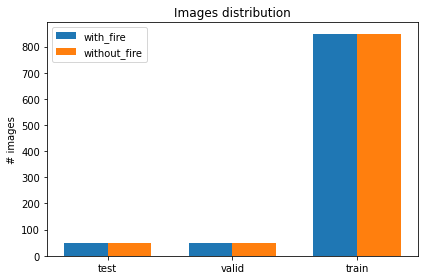

In [6]:
labels = ['with_fire', 'without_fire']
datasets = []
with_mask = []
without_mask = []

for folder_name in os.listdir():
    path = os.path.join(project_dir, 'data', 'fire-vs-without-fire', folder_name)
    
    datasets.append(folder_name)
    
    for children_name in os.listdir(path):
        child_path = os.path.join(path, children_name)
        if children_name == labels[0]:
            with_mask.append(len(os.listdir(child_path)))
        else:
            without_mask.append(len(os.listdir(child_path)))
            
x = np.arange(len(datasets))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, with_mask, width, label=labels[0])
rects2 = ax.bar(x + width/2, without_mask, width, label=labels[1])

ax.set_ylabel('# images')
ax.set_title('Images distribution')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.legend()

fig.tight_layout()
plt.show()

In [7]:
# going back to root directory
os.chdir(project_dir)

In [8]:
train_path = f'{project_dir}/data/fire-vs-without-fire/train'
valid_path = f'{project_dir}/data/fire-vs-without-fire/valid'
test_path = f'{project_dir}/data/fire-vs-without-fire/test'

In [9]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224, 224), classes=['with_fire', 'without_fire'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['with_fire', 'without_fire'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224, 224), classes=['with_fire', 'without_fire'], batch_size=10, shuffle=False)

Found 1700 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [10]:
# This function will plot images in the form of a grid with 1 row and 10 columns where 
# images are placed
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
img, labels = next(train_batches)  # gets a single batch of imgs and labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


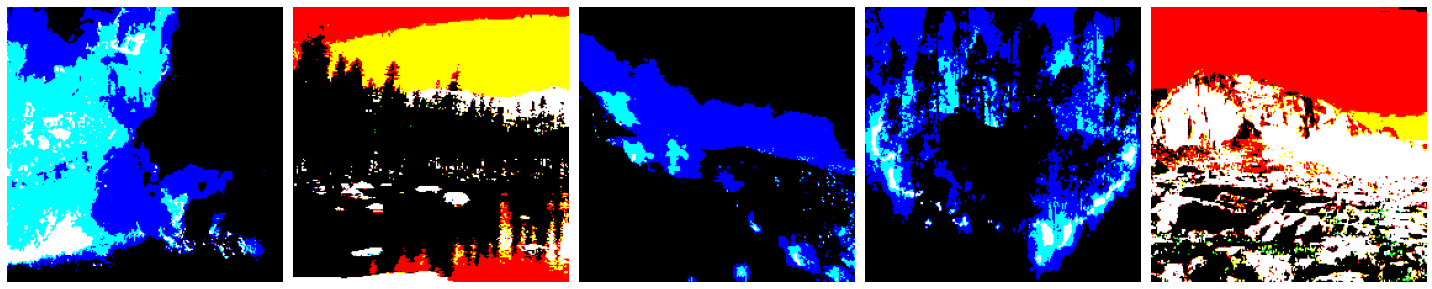

In [12]:
plotImages(img)

## Importing VGG16 model

In [13]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [14]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [16]:
for layer in model.layers[:-2]:
    layer.trainable = False

In [17]:
model.add(Dense(units=2, activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

# Train the fine-tuned VGG16 model

In [19]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
n_epochs = 15

history = model.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=n_epochs,
          verbose=1
)

Epoch 1/15
170/170 [==============================] - 160s 939ms/step - loss: 0.1826 - accuracy: 0.9747 - val_loss: 0.0456 - val_accuracy: 0.9800
Epoch 2/15
170/170 [==============================] - 163s 959ms/step - loss: 0.0158 - accuracy: 0.9947 - val_loss: 0.0672 - val_accuracy: 0.9900
Epoch 3/15
170/170 [==============================] - 167s 981ms/step - loss: 0.0204 - accuracy: 0.9971 - val_loss: 0.2400 - val_accuracy: 0.9900
Epoch 4/15
170/170 [==============================] - 166s 979ms/step - loss: 0.0379 - accuracy: 0.9965 - val_loss: 0.5179 - val_accuracy: 0.9400
Epoch 5/15
170/170 [==============================] - 167s 984ms/step - loss: 0.0631 - accuracy: 0.9959 - val_loss: 0.0238 - val_accuracy: 0.9900
Epoch 6/15
170/170 [==============================] - 168s 987ms/step - loss: 0.0147 - accuracy: 0.9976 - val_loss: 0.2261 - val_accuracy: 0.9600
Epoch 7/15
170/170 [==============================] - 169s 991ms/step - loss: 0.0155 - accuracy: 0.9982 - val_loss: 3.3899e-

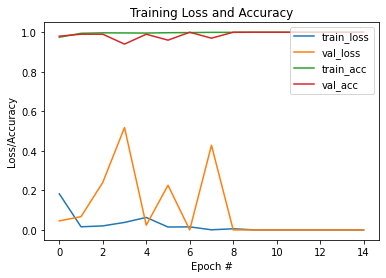

In [21]:
plt.figure()
plt.plot(np.arange(0, n_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()

# Convert Model to tflite

In [22]:
# model.save('models/firenet.h5', save_format='h5')

In [23]:
# keras_model = tf.keras.models.load_model('models/firenet.h5')

In [24]:
# converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
# tflite_model = converter.convert()

# with open('models/firenet-lite.tflite', 'wb') as f:
#       f.write(tflite_model)

# Predict using fine-tuned VGG16 model

In [ ]:
predictions = model.predict(x=test_batches, verbose=0)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [ ]:
cm_plot_labels = ['with_fire', 'without_fire']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)

In [ ]:
# Classification report
print(classification_report(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)))

In [ ]:
batch_size = 10
pred_labels = np.argmax(predictions, axis=-1)
index = 0

mislabeled_images = []
mislabeled_labels = []
true_labels = []

for i in range(0, len(test_batches)):
    img, labels = next(test_batches)
    labels = np.argmax(labels, axis=-1)
    
    predicted_labels = pred_labels[index:(index + batch_size)]
    
    corrected_predicted = (labels == predicted_labels)
    mislabeled_indices = np.where(corrected_predicted == 0)[0]
        
    if(len(mislabeled_indices) != 0):        
        mislabeled_images += [img for img in img[mislabeled_indices]]
        mislabeled_labels += [label for label in predicted_labels[mislabeled_indices]]
        true_labels += [label for label in labels[mislabeled_indices]]
        
    index += batch_size

In [ ]:
def display_examples(class_names, mislabeled_images, mislabeled_labels, true_labels):
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle("Some images that where incorrected predicted", fontsize=16, x= 0.5, y=0.98)
    for i in range(len(mislabeled_images)):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(mislabeled_images[i], cmap=plt.cm.binary)
        plt.xlabel('prediction: {}\n label: {}'.format(class_names[mislabeled_labels[i]], class_names[true_labels[i]]))
    plt.show()

In [ ]:
display_examples(['with_fire', 'without_fire'], mislabeled_images[:5], mislabeled_labels[:5], true_labels[:5])